In [1]:
# Import the toolkit
from medimg_toolkit import MedicalImageProcessor
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Initialize processor
processor = MedicalImageProcessor()

MedicalImageProcessor initialized.


In [2]:
def compare_images(images, image_titles=None, title="Image Comparison"):
    """Helper function to compare multiple images side by side."""
    n = len(images)
    plt.figure(figsize=(5 * n, 5))
    plt.suptitle(title, fontsize=16)
    for i, img in enumerate(images):
        plt.subplot(1, n, i + 1)
        if image_titles is not None:
            plt.title(image_titles[i])
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## 1. Data Loading & Visualization

The toolkit supports standard medical imaging formats including **DICOM** and **NIfTI**.
Here we load a NIfTI volume and a DICOM series to demonstrate I/O capabilities.

NIfTI Volume Shape: (64, 64, 35)


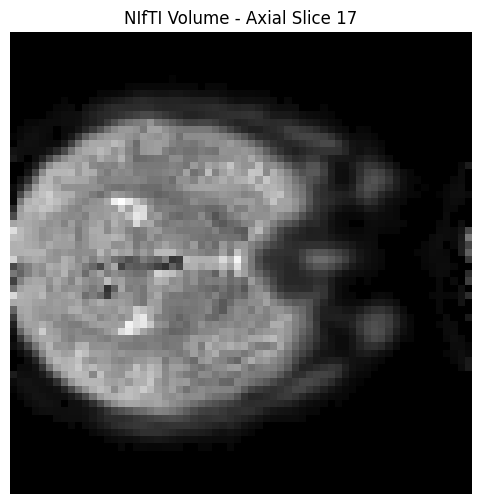

In [3]:
# Load a NIfTI file
nifti_path = 'Images/brain.nii'
brain_volume, nifti_meta = processor.load_nifti(nifti_path, return_metadata=True)

# Load a DICOM series
# dicom_dir = 'Images/DICOM' # Replace with your DICOM directory path
# volume_dicom, metadata = processor.load_dicom_series(dicom_dir)

print(f"NIfTI Volume Shape: {brain_volume.shape}")
#print(f"DICOM Volume Shape: {volume_dicom.shape}")


# Visualize the middle slice of the NIfTI volume
mid_slice = brain_volume.shape[2] // 2
plt.figure(figsize=(6, 6))
plt.imshow(brain_volume[:, :, mid_slice], cmap='gray')
plt.title(f'NIfTI Volume - Axial Slice {mid_slice}')
plt.axis('off')
plt.show()

## 2. Image Enhancement

Medical images often contain noise or have poor contrast. The toolkit provides methods for:
- **Denoising**: Removing Gaussian/Speckle noise.
- **Auto-leveling**: Improving contrast distribution.
- **Gamma Correction**: Adjusting luminance.

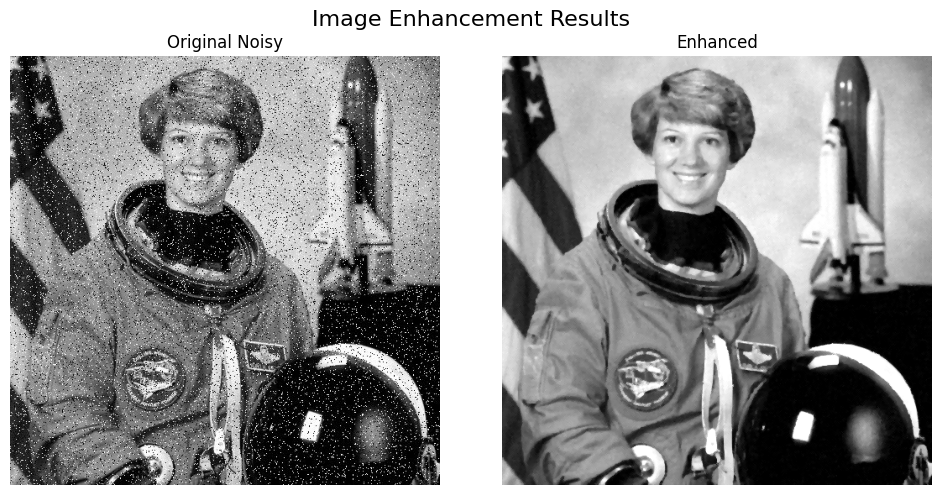

In [4]:
# Load a noisy sample image
image_path = "Images/astronaut_noisy.jpg"
noisy_image = imread(image_path)

# Apply enhancement
enhanced_image = processor.enhance_image(
    noisy_image,
    denoise_radius=2,
    auto_level_percentiles=(2, 98)
)

# Compare results
compare_images(
    [noisy_image, enhanced_image], 
    ["Original Noisy", "Enhanced"], 
    "Image Enhancement Results"
)

## 3. Image Segmentation

Segmentation partitions an image into meaningful regions. We demonstrate:
1.  **2D Segmentation**: Using Otsu's method and Watershed algorithm.
2.  **3D Volume Segmentation**: Applying algorithms across volumetric data.

using bad ones


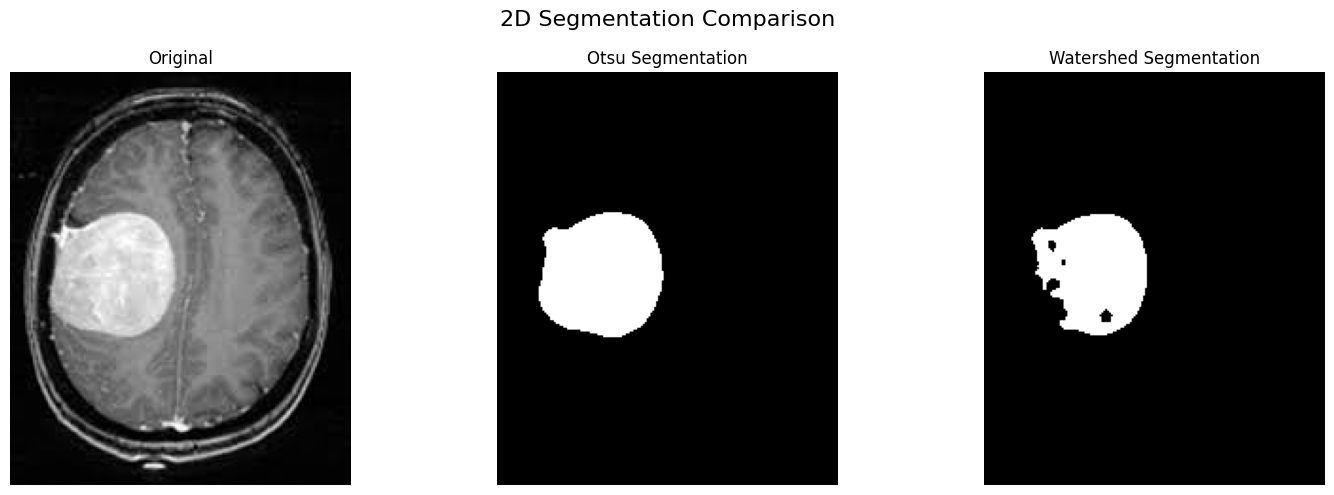

In [ ]:
# Load brain MRI
brain_mri = imread("Images/mri_brain.jpg", as_gray=True)

# Preprocess
denoised = processor.denoise(brain_mri, radius=3)

# Apply different segmentation methods
seg_otsu = processor.segment_image(
    denoised, 
    method='histogram', 
    remove_background=True
)
seg_watershed = processor.segment_image(
    denoised, 
    method='watershed', 
    remove_background=True
)

# Visualize
compare_images(
    [brain_mri, seg_otsu, seg_watershed],
    ["Original", "Otsu Segmentation", "Watershed Segmentation"],
    "2D Segmentation Comparison"
)

### 3D Volume Segmentation

The toolkit can process entire NIfTI volumes or specific slices while preserving intensity values.

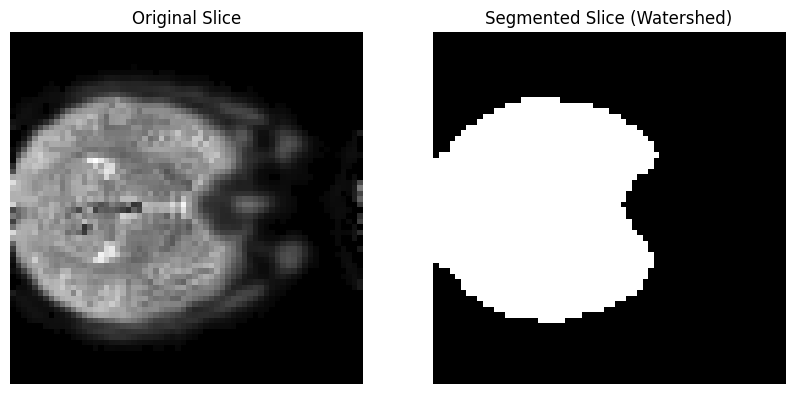

In [6]:
# Segment the NIfTI volume
# We'll segment the middle slice for demonstration, but the method supports full volume
mid_slice_idx = brain_volume.shape[2] // 2

segmented_slice = processor.segment_volume(
    nifti_path,
    method='watershed',
    slice_axis=2,
    slice_idx=mid_slice_idx,
    preserve_intensities=True
)

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(brain_volume[:, :, mid_slice_idx], cmap='gray')
plt.title('Original Slice')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_slice, cmap='gray')
plt.title('Segmented Slice (Watershed)')
plt.axis('off')
plt.show()

## 4. Image Registration

Image registration aligns two images (fixed and moving) into a common coordinate system.
We support **Rigid** (translation + rotation) and **Affine** (scaling + shearing) transformations.

Running Affine Registration...


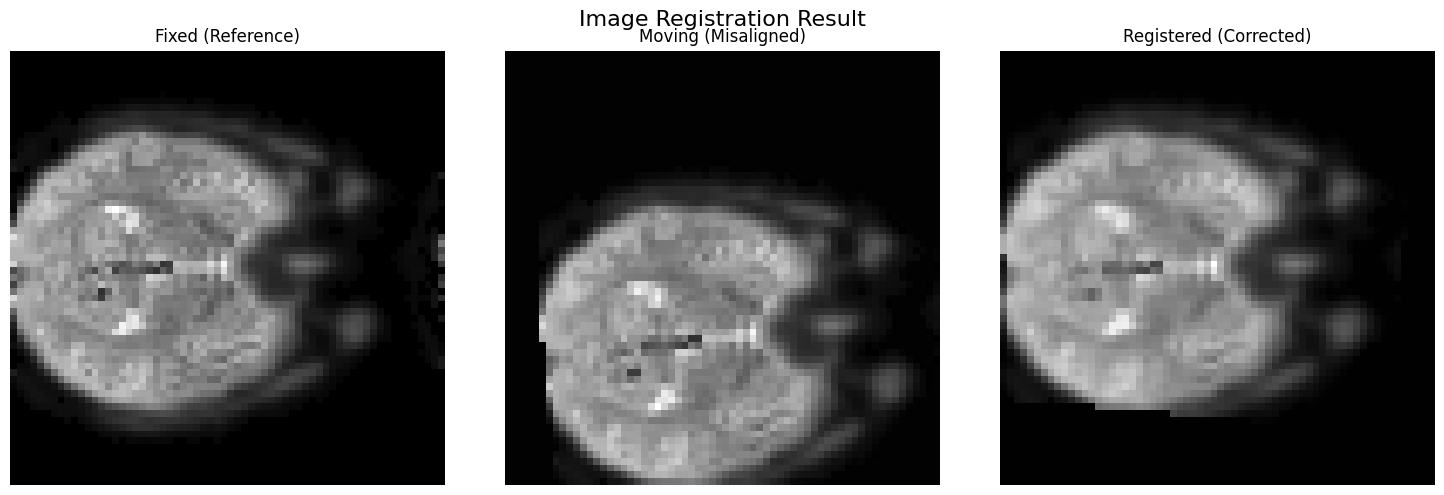

In [7]:
# Create a synthetic misalignment for demonstration
fixed_image = brain_volume[:, :, mid_slice_idx]
from scipy.ndimage import shift, rotate
moving_image = shift(rotate(fixed_image, 5, reshape=False), [10, 5])

# Save to temporary files for the registration tool
import tempfile, os, shutil
import nibabel as nib

temp_dir = tempfile.mkdtemp()
fixed_path = os.path.join(temp_dir, 'fixed.nii.gz')
moving_path = os.path.join(temp_dir, 'moving.nii.gz')

nib.save(nib.Nifti1Image(fixed_image, np.eye(4)), fixed_path)
nib.save(nib.Nifti1Image(moving_image, np.eye(4)), moving_path)

# Perform registration
print("Running Affine Registration...")
reg_result = processor.register_images_ants(
    fixed_img=fixed_path,
    moving_img=moving_path,
    transform_type='Affine'
)

# Visualize
compare_images(
    [fixed_image, moving_image, reg_result['warpedmovout'].numpy()],
    ["Fixed (Reference)", "Moving (Misaligned)", "Registered (Corrected)"],
    "Image Registration Result"
)

# Cleanup
shutil.rmtree(temp_dir)

## 5. Quantitative Analysis

To objectively evaluate processing results, we compute similarity metrics such as:
- **MSE** (Mean Squared Error)
- **SSIM** (Structural Similarity Index)
- **Dice Coefficient** (for segmentation overlap)

In [8]:
# Compute similarity metrics between the fixed and registered images
metrics = processor.compute_all_metrics(fixed_image, reg_result['warpedmovout'].numpy())

print("Registration Accuracy Metrics:")
print("-" * 30)
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

Registration Accuracy Metrics:
------------------------------
MSE: 3237.3038
MAE: 20.8444
PSNR: 28.8088
NCC: 0.9901
MI: 1.8889
NMI: 1.4887
SSIM: 0.9090


## 6. Shape Analysis

The toolkit can identify and classify geometric shapes within binary images, useful for feature extraction.

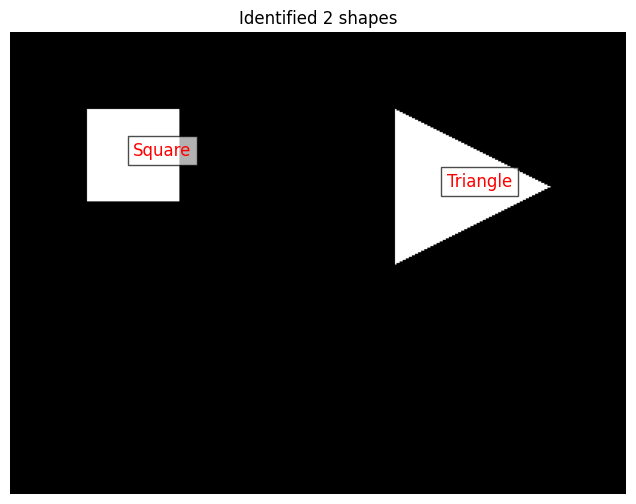

In [9]:
# Create a synthetic image with shapes
from skimage.draw import rectangle, polygon
shape_img = np.zeros((300, 400), dtype=np.uint8)

rr, cc = rectangle(start=(50, 50), extent=(60, 60))
shape_img[rr, cc] = 255
rr, cc = polygon([50, 100, 150], [250, 350, 250])
shape_img[rr, cc] = 255

# Identify shapes
shapes = processor.identify_shapes(shape_img)

# Visualize
plt.figure(figsize=(8, 6))
plt.imshow(shape_img, cmap='gray')
for centroid, cls in zip(shapes['centroids'], shapes['classifications']):
    # Note: regionprops returns (row, col), but plots use (x, y) -> (col, row)
    plt.text(centroid[1], centroid[0], cls, color='red', fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.7))
plt.title(f"Identified {len(shapes['classifications'])} shapes")
plt.axis('off')
plt.show()

## 7. Complete Processing Pipeline

Combining multiple steps into a seamless workflow: **Load -> Enhance -> Segment**.

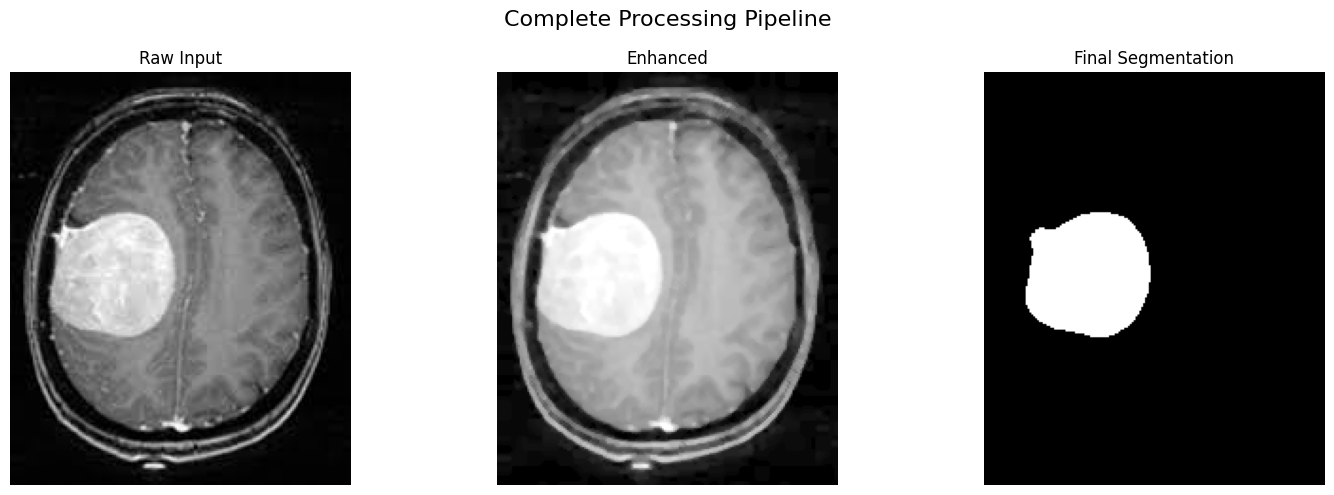

In [10]:
# Full pipeline: Load -> Enhance -> Segment
raw_img = imread("Images/mri_brain.jpg")
enhanced = processor.enhance_image(raw_img, denoise_radius=2)
segmented = processor.segment_image(
    enhanced, 
    method='histogram', 
    remove_background=True
    )

compare_images(
    [raw_img, enhanced, segmented],
    ["Raw Input", "Enhanced", "Final Segmentation"],
    "Complete Processing Pipeline"
)